In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from ai_quantum.utils.matrix_compression import opt_sort_matrix_ring, compress_matrix
from return_cov import f_return_cov
import networkx as nx

from ai_quantum.ai_models.gpt2 import GPT2_QAOA
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Cov Matrix compression

In [3]:
opt_perm = opt_sort_matrix_ring(np.array(cov_matrix))

q_graph = [
 (opt_perm[i], opt_perm[np.mod(i+1, len(expected_value))]) 
 for i in range(len(expected_value))
]
q_graph

[(0, 1), (1, 3), (3, 4), (4, 2), (2, 0)]

In [4]:
G = nx.Graph()
G.add_edges_from(q_graph)
lam, compress_cov_matrix = compress_matrix(cov_matrix[opt_perm], G)
compress_cov_matrix = pd.DataFrame(compress_cov_matrix)

## Neural Networking model

In [5]:
def f_loss(energies, sum_w):
    response = torch.mean((torch.exp(-sum_w)-torch.exp(-energies)).pow(2))
    return response

In [6]:
def epoch_train(model, optimizer, batch_size, beta_temp, depth):
    sum_w, energies, count, gamma, beta = model.forward_qc(beta_temp, depth)
    for _ in range(batch_size):
        sum_w_, energy_, count, gamma, beta = model.forward_qc(beta_temp, depth)
        sum_w = torch.cat((sum_w, sum_w_), dim=0)
        energies = torch.cat((energies, energy_), dim=0)
    
    optimizer.zero_grad()
    loss = f_loss(energies, sum_w)
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [7]:
q = 0.5 
B  = 2 
lamb= 0
qc_initial_state = dicke_statevector(len(expected_value), B)

vocab_size = 100
max_depth = 30

In [8]:
nn_qaoa = GPT2_QAOA(vocab_size, max_depth, expected_value, compress_cov_matrix, q, B, lamb, qc=qc_initial_state, 
                    mixture_layer='ring_mixer', q_graph=q_graph)
optimizer = optim.Adam(nn_qaoa.parameters(), lr=1e-20)

## Model Training

In [9]:
depth = 10
beta_temp = 1

batch_size = 1
epochs = 30

In [10]:
for i in range(epochs):
    loss_i = epoch_train(nn_qaoa, optimizer, batch_size, beta_temp, depth)
    print(f"Epoch {i}, Loss: {loss_i:.2f}")

Epoch 0, Loss: 4580419791.50
Epoch 1, Loss: 1039439597.21
Epoch 2, Loss: 1314642.61
Epoch 3, Loss: 10588678.94
Epoch 4, Loss: 2560629375.59
Epoch 5, Loss: 485998635.00
Epoch 6, Loss: 81509.97
Epoch 7, Loss: 36086408.69
Epoch 8, Loss: 411429277.06
Epoch 9, Loss: 938350.66
Epoch 10, Loss: 528.12
Epoch 11, Loss: 2640085.54
Epoch 12, Loss: 25807046.94
Epoch 13, Loss: 310512.16
Epoch 14, Loss: 70319095178.85
Epoch 15, Loss: 230279.11
Epoch 16, Loss: 406617.96
Epoch 17, Loss: 206698.85
Epoch 18, Loss: 222760974.00
Epoch 19, Loss: 9240896764944.19
Epoch 20, Loss: 9904.12
Epoch 21, Loss: 734367248.94
Epoch 22, Loss: 63559162.66
Epoch 23, Loss: 376941542.44
Epoch 24, Loss: 753944.17
Epoch 25, Loss: 17698469.56
Epoch 26, Loss: 8764173.17
Epoch 27, Loss: 76004364.89
Epoch 28, Loss: 373441514.52
Epoch 29, Loss: 38595008638.33


## Inference

In [11]:
nn_qaoa.eval()
with torch.no_grad():
    w, energy, count, gamma, beta = nn_qaoa.forward_qc(100000, depth)
energy

tensor([-0.0958], dtype=torch.float64)

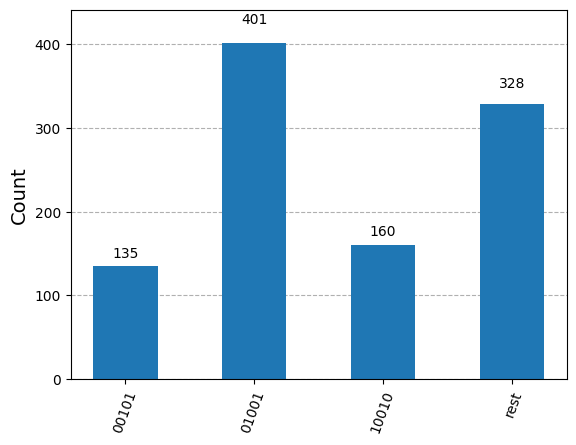

In [12]:
plot_histogram(count, number_to_keep=3)
plt.show()

In [13]:
q_graph

[(0, 1), (1, 3), (3, 4), (4, 2), (2, 0)]

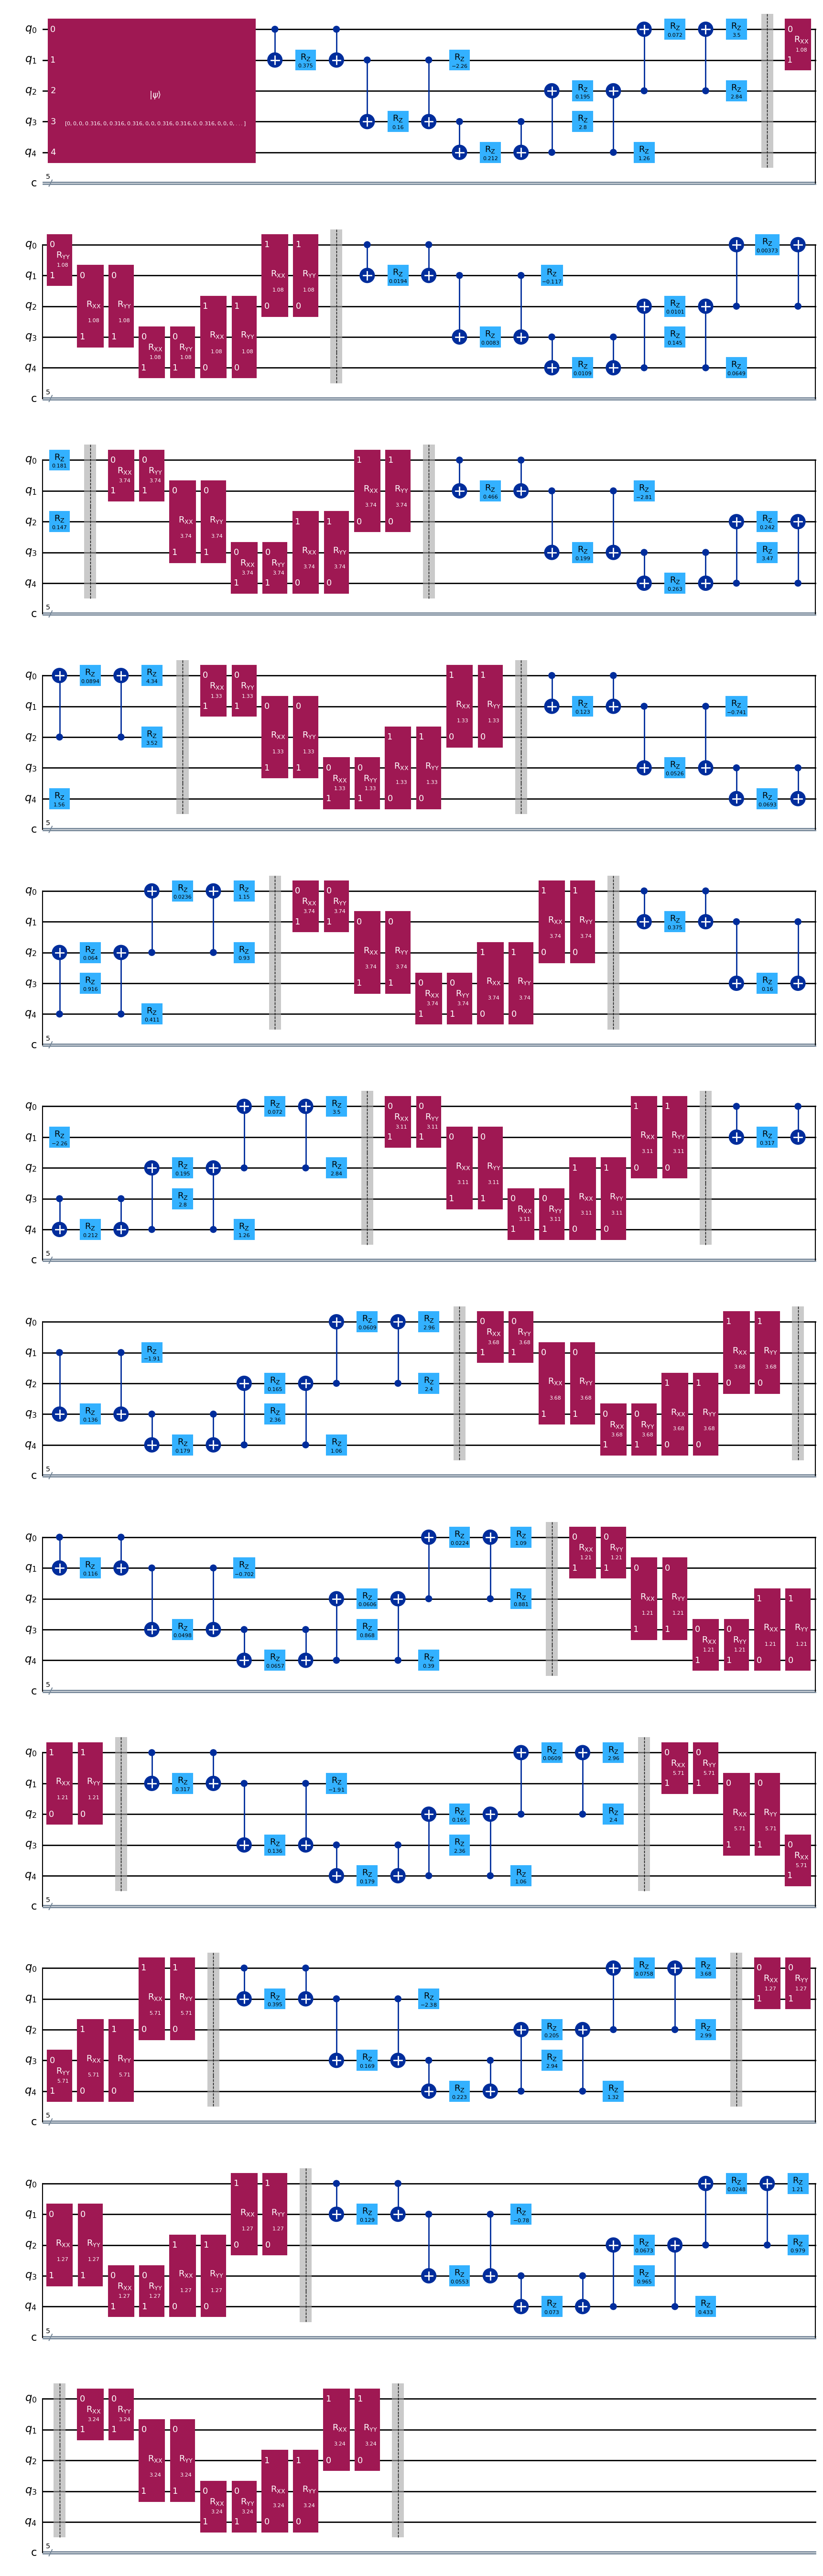

In [14]:
qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb, qc=qc_initial_state, mixture_layer='ring_mixer', q_graph=q_graph)
for i in range(len(gamma)):
    qaoa.add_layer(gamma[i], beta[i])
qaoa.draw()